In [4]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA


# REF_PATH : reference dataset path
# CONFUSION_PATH : benchmark1
# EXCHANGE_PATH : benchmark2

REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"

CONFUSION_PATH = "/home/yifan/dataset/confusion/pairflip/cifar10/0"
EXCHANGE_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"
NOISE_2500 = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy2500"

sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

confusion_provider = NormalDataProvider(CONFUSION_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

exchange_provider = NormalDataProvider(EXCHANGE_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

clean_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

noise_provider = NormalDataProvider(NOISE_2500, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )

ref_train_data = ref_provider.train_representation(200).squeeze()

confusion_data = confusion_provider.train_representation(200).squeeze()

exchange_data = exchange_provider.train_representation(200).squeeze()

clean_data = clean_provider.train_representation(200).squeeze()

import json
# filename = 'ref_ref_tar_clean.json'
# with open(filename, 'r', encoding='utf-8') as file_obj:
#     R = json.load(file_obj)

# with open('tar_ref_ref_clean1.json', 'r', encoding='utf-8') as file_obj:
#     RT = json.load(file_obj)

# print(RT)

    # if clean_labels[i] == 8:
    #     label3_indicates.append(i)

model = VisModel(ENCODER_DIMS, DECODER_DIMS)

Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [14]:
import json
import os
import numpy as np
clean_path = os.path.join(EXCHANGE_PATH, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(EXCHANGE_PATH, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
# noisy_indicates = []
# clean_indicates = []
selected_indicated = []
# pairs = []
for i in range(len(clean_labels)):
    # if clean_labels[i] != 3 and clean_labels[i] != 2:
    if clean_labels[i] == 2:
        selected_indicated.append(i)
        # pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})

print(len(selected_indicated))

5000


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 455.02it/s]


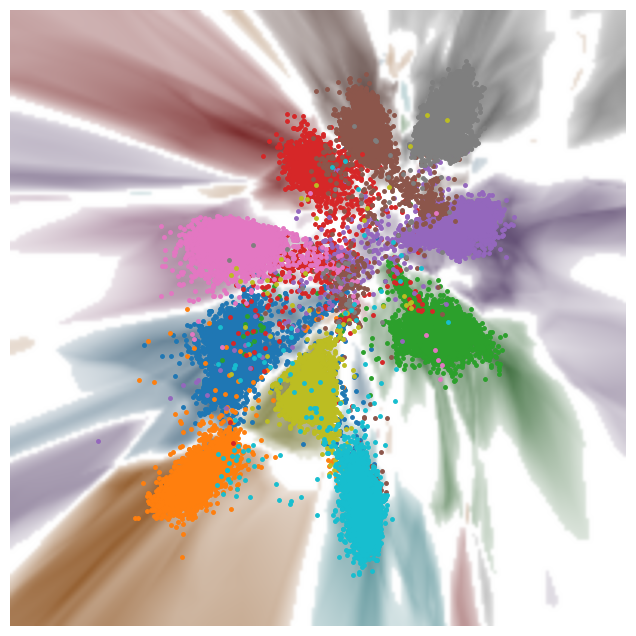

In [17]:
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9710.12it/s]


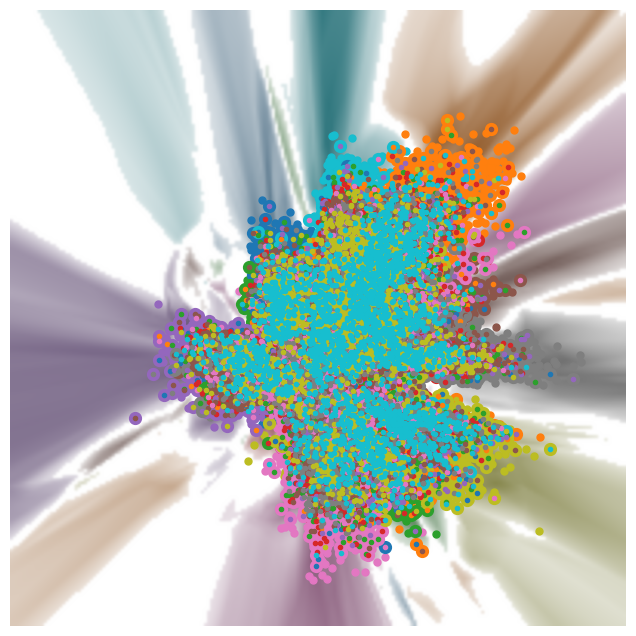

In [27]:
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
with open('benckmark2_ref_clean_tar_ref_R_pred.json','r', encoding='utf-8') as file_obj:
    R_pred = json.load(file_obj)
I = np.eye(512)   
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_cc import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, RT, np.dot(ref_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9388.52it/s]


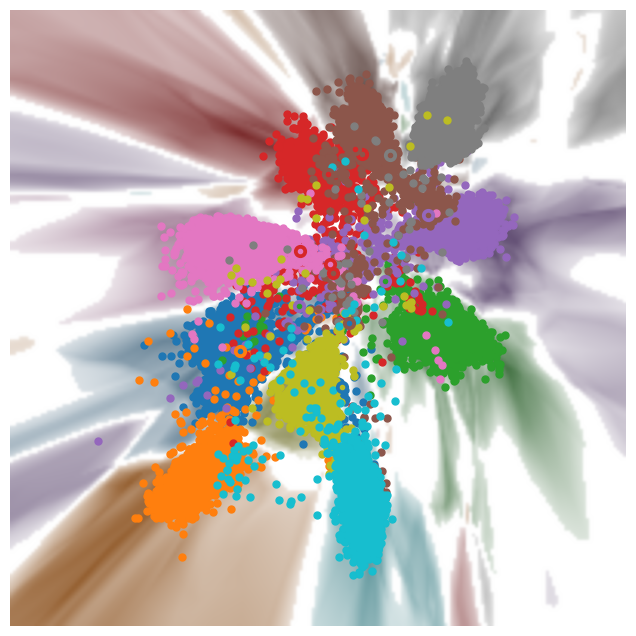

In [43]:

I = np.eye(512) 
I2 =  np.eye(10) 
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_use_pred_R_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I, I2, np.dot(ref_provider.train_representation(200),I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 10004.06it/s]


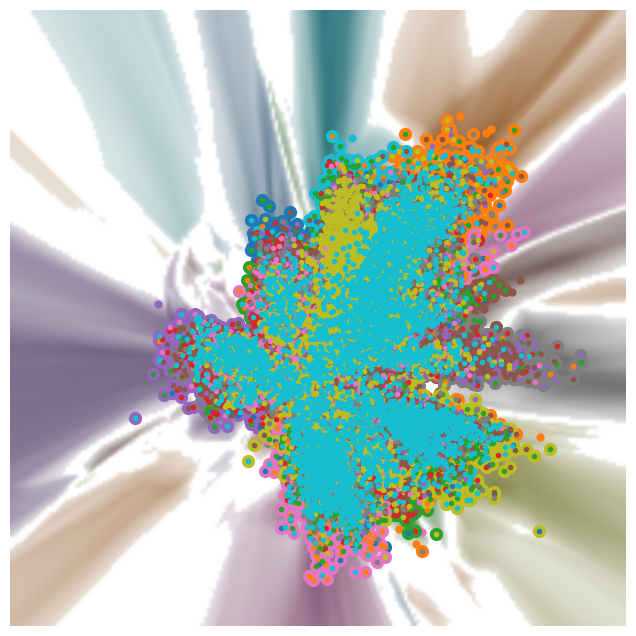

In [65]:
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
with open('benckmark2_ref_clean_tar_ref_R_pred.json','r', encoding='utf-8') as file_obj:
    R_pred = json.load(file_obj)
I = np.eye(512)   
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_use_pred_R_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, RT, R_pred, np.dot(ref_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9447.14it/s]


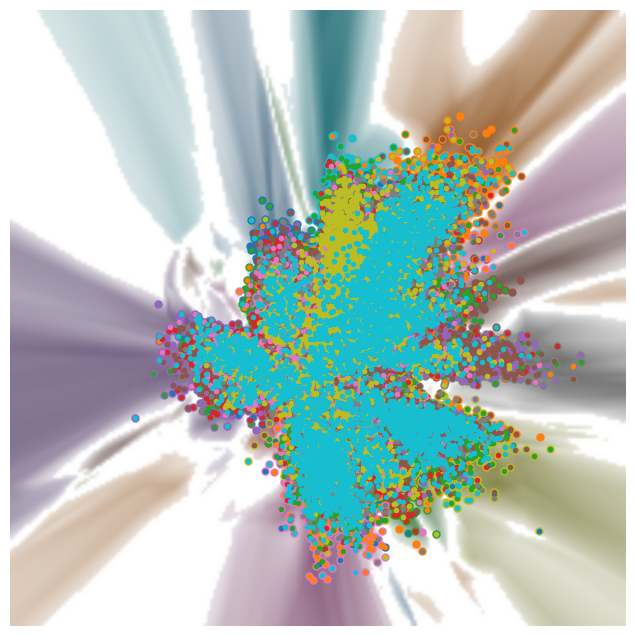

In [70]:
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
with open('benckmark2_ref_clean_tar_ref_R_pred.json','r', encoding='utf-8') as file_obj:
    R_pred = json.load(file_obj)
I = np.eye(512)   
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
tar_projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.test19 import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, RT, R_pred, np.dot(ref_provider.train_representation(200),R), projector,tar_projector,R, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [51]:
ref_provider.train_representation(200)[0:40000].shape

(40000, 512)

In [13]:
pred_transBefore = ref_provider.get_pred(200, ref_provider.train_representation(200))
pred_transAfter = ref_provider.get_pred(200, np.dot(clean_provider.train_representation(200),RT) )

100%|██████████| 250/250 [00:00<00:00, 9191.34it/s]


In [ ]:
print(pred_transBefore)

In [ ]:
from torch import nn


import scipy
import numpy as np
from sklearn.cross_decomposition import CCA
import torch.nn.functional as F
from torch.autograd import Variable



# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps: int=20000,
                      learning_rate: float=0.003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    # R = np.random.rand(X.shape[1], X.shape[1])
    R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

    m = len(X)

    rows, columns = X.shape


    for i in range(train_steps):
        X = torch.Tensor(X)
        Y = torch.Tensor(Y)
        Xnew = torch.mm(X, R)
        loss = ((( X.matmul(R) - Y)**2).sum())/m
        loss.backward()
        if i % 50 == 0:
            print("iteration:",i,'losss:',loss)
        # grad = (np.dot(X.detach().numpy().T, np.dot(X.detach().numpy(), R.detach().numpy()) - Y.detach().numpy()) * 2)/rows

        R.data = R.data - learning_rate * R.grad.data

        R.grad.data.zero_()
    return R

X = pred_transAfter
Y = pred_transBefore
R_pred = align_embeddings(X, Y)
print(R_pred)


In [41]:
import json
filename = now = time.strftime("benckmark2_ref_clean_tar_ref_R_pred.json", time.localtime(time.time())) 
rlist = json.dumps(R_pred.detach().numpy().tolist())
with open(filename, 'w', encoding='utf-8') as file_obj:

    file_obj.write(rlist)

In [ ]:
print(R_pred.detach().numpy())

In [2]:
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_provider, RT,I, np.dot(clean_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

NameError: name 'model' is not defined

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 10270.19it/s]


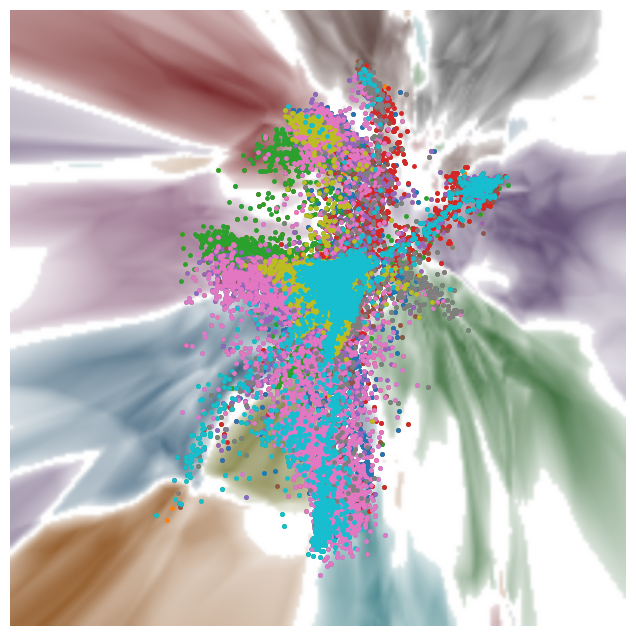

In [6]:
with open('ref_ex_R1.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('ref_ex_R2.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
I = np.eye(512)
R_V = np.linalg.inv(R)
RT_V = np.linalg.inv(RT)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I, I, np.dot(np.dot(exchange_provider.train_representation(200),I),I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...
grid [[-12.44592667 -12.44592667]
 [-12.35152194 -12.44592667]
 [-12.25711722 -12.44592667]
 ...
 [  6.15180392   6.34061337]
 [  6.24620864   6.34061337]
 [  6.34061337   6.34061337]]


100%|██████████| 250/250 [00:00<00:00, 456.84it/s]


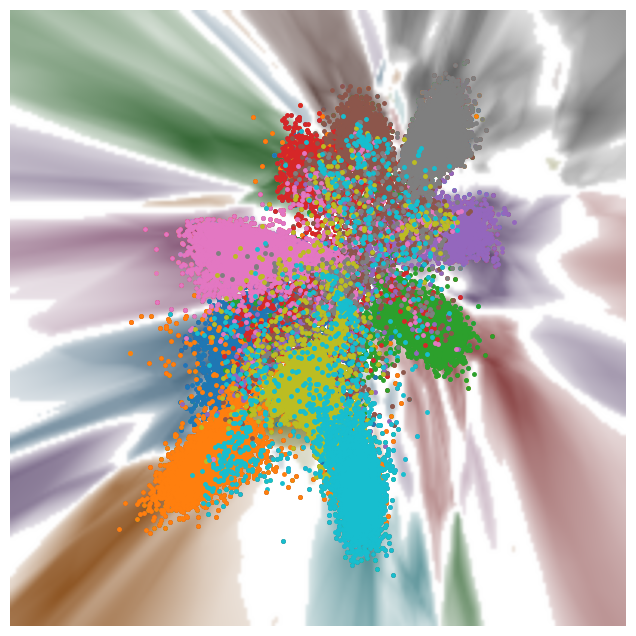

In [23]:
with open('ex.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('ref_ex_tar_ref.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(exchange_provider, RT, np.dot(exchange_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [2]:
###  ============================= caculate cca ============================== ###
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = np.dot(ref_train_data,RT.I)
Y = clean_data
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('Xj vs XjR ')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Xj vs XjR 
0.9759769774390745


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9404.94it/s]


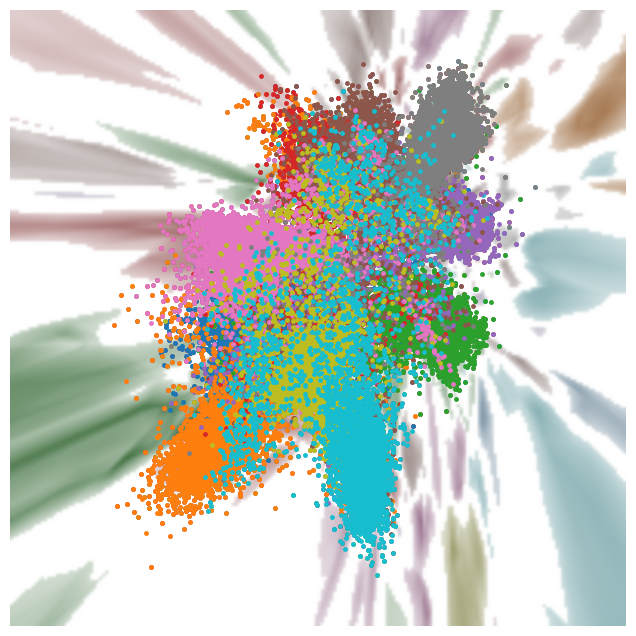

In [3]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, np.dot(clean_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)
vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))